In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=3b23d2e4fde54e02c0507b39cedd0870ad99030fd735da709805c1efa6f10799
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [ ]:
import torch
from torch import nn
import numpy as np

from scipy.io import wavfile
import seaborn as sns
from matplotlib import cm
import matplotlib.pyplot as plt
import python_speech_features as psf
%matplotlib inline

In [ ]:
print(torch.__version__)
print(torch.cuda.get_device_name(0))

## google colab GPU set up
device = torch.device('cuda:0')
#device = 'cpu'
print("device:", device)

1.10.0+cu111
Tesla K80
device: cuda:0


In [ ]:
!nvidia-smi

Tue Dec 14 19:23:59 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def MFCC_feature_extraction_psf(wav_file):
    # Mel-frequency cepstral coefficients
    # DFT
    # https://jonathan-hui.medium.com/speech-recognition-feature-extraction-mfcc-plp-5455f5a69dd9
    # https://python-speech-features.readthedocs.io/en/latest/
    fs, sig = wavfile.read(wav_file)
    
    #mfccs = psf.mfcc(sig, samplerate=16000)
    #mfccs = psf.mfcc(sig, samplerate=fs, nfft=1200)
    mfccs = psf.mfcc(sig, samplerate=fs, numcep=13, nfft=1200, appendEnergy=False) # [999,13]
    
    fig, ax = plt.subplots()
    mfccs_data = np.swapaxes(mfccs, 0 ,1) # [13,999]
    cax = ax.imshow(mfccs_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower')
    ax.set_title('MFCC')

    plt.show()
    plt.plot(mfccs_data)
    
    return mfccs_data

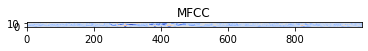

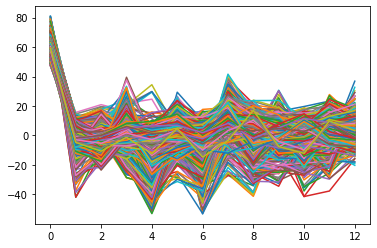

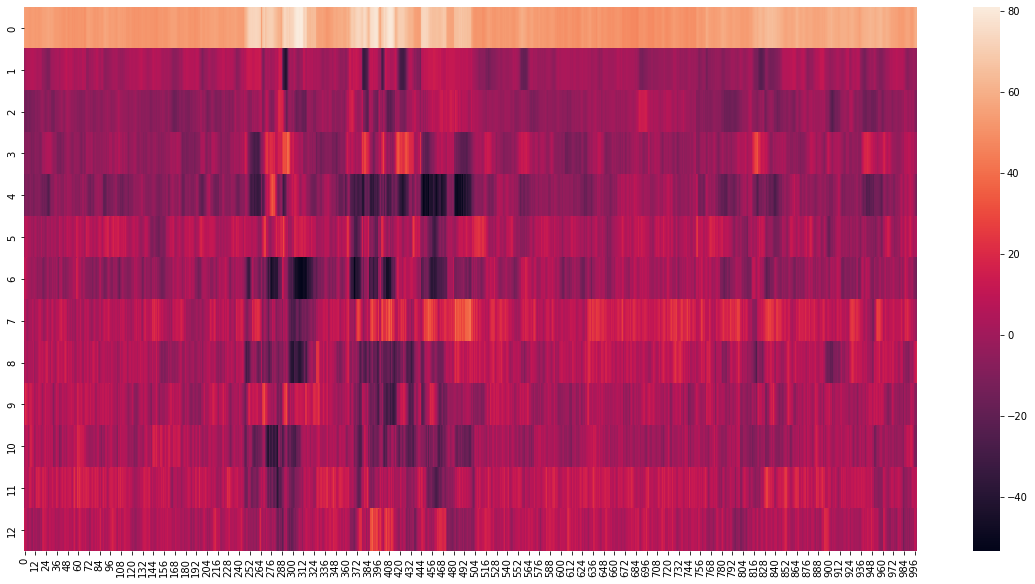

In [ ]:
x = MFCC_feature_extraction_psf("4_8_train.wav")
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(x)

In [ ]:
class Voice_awake_RNN(nn.Module):
  def __init__(self):
    super(Voice_awake_RNN, self).__init__()
    
    self.loss_fct = nn.BCELoss()
    self.conv = nn.Sequential(
        nn.Conv1d(in_channels=13, out_channels=26, kernel_size=15, stride=4),
        nn.BatchNorm1d(num_features=26), #(batch size,num_channel,length)
        nn.ReLU(),
        nn.Dropout(p=0.8),
    )
    
    self.biRNN = nn.GRU(input_size=26,hidden_size=13,batch_first=True,dropout=0.2,bidirectional=True)
    
    self.dropout = nn.Dropout(p=0.8)
    self.batchNorm1 = nn.BatchNorm1d(num_features=26)
    self.batchNorm2 = nn.BatchNorm1d(num_features=16)
    
    self.RNN = nn.GRU(input_size=26,hidden_size=16,batch_first=True)
    
    self.classifier = nn.Sequential(
        nn.Linear(in_features=16,out_features=1),
        nn.Sigmoid(),
    )

  def forward(self, x, labels=None):
    x = self.conv(x)
    
    # [batch size, num channel, sequence length] to 
    # [batch size, sequence length, input size]
    x = torch.swapaxes(x,1,2)
    residual_x, hn = self.biRNN(x)
    
    x += residual_x.detach()
    x, hn = self.biRNN(x)
    x = torch.swapaxes(x,1,2)
    
    x = self.dropout(x)
    x = self.batchNorm1(x)
    
    x = torch.swapaxes(x,1,2)
    x,hn = self.RNN(x)
    x = torch.swapaxes(x,1,2)
    
    x = self.dropout(x)
    x = self.batchNorm2(x)
    x = self.dropout(x)
    
    x = torch.swapaxes(x,1,2)
    
    outputs = self.classifier(x)
    
    if labels != None:
      loss = self.loss_fct(outputs, labels)

      return outputs, loss
    
    return outputs # [number of data, 247, 1]

In [ ]:
# Train function
def train(model, optimizer, epoch, train_dataloader):
  model.train()
  train_loss_list = []
  for ep in range(epoch):
    total_loss = 0
    print("Epoch:", ep+1)
    for x, y in train_dataloader:
      x = torch.tensor(x).float().to(device)
      y = torch.tensor(y).float().to(device)

      # Forward pass
      outputs, loss = model(x, y)
      
      total_loss += loss

      print("Loss:",loss)
      # Back propagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
    train_loss_list.append(total_loss)
    print("Total loss:", total_loss)

  return model, train_loss_list

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip -q "/content/drive/My Drive/data_normalize2RMS_mfcc_15step_BGNenhanced7dB_HalfLabel0_insertRange[0_4].zip" #MFCC normalized-RMS 0.6 7db complexity sec

In [ ]:
# Load data
x = np.load("X_train.npy") # [number of data, 13, 999]
y = np.load("y_train.npy") # [number of data, 1, 247]

# Mini-batch data loader
train_dataloader = []
y = np.swapaxes(y, 1, 2) # [number of data, 247, 1]
mini_size = 0.2
L = x.shape[0]

for i in range(int(1/mini_size)):
  train_dataloader.append((x[int(mini_size*L*i):int(mini_size*L*(i+1)),:,:],y[int(mini_size*L*i):int(mini_size*L*(i+1)),:,:]))

In [ ]:
net = Voice_awake_RNN()
net.to(device)

optimizer = torch.optim.AdamW(net.parameters(), lr=0.01, 
    betas=(0.9,0.999), eps=1e-08, weight_decay=0.01
)

loss_fct = nn.BCELoss() # binary cross entropy, https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html#torch.nn.BCELoss

epoch = 200

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


In [ ]:
# Train lr = 0.01 epoch = 200
net, train_loss = train(net, optimizer, epoch, train_dataloader)

Epoch: 1
Loss: tensor(0.8708, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.8452, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.8155, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.7903, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.7653, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Total loss: tensor(4.0871, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 2
Loss: tensor(0.7540, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.7272, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.7184, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.7013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Loss: tensor(0.6863, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Total loss: tensor(3.5871, device='cuda:0', grad_fn=<AddBackward0>)
Epoch: 3
Loss: tensor(0.6808, device='cuda:0', grad_fn=<BinaryCrossEntropyBa

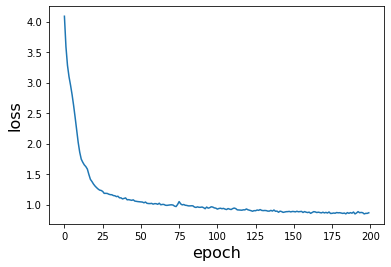

In [ ]:
plt.figure()
#plt.plot(k_range, trnErr.values(), marker='^', linewidth=3, markersize=12)
#plt.xticks(k_range, fontsize=12)
#plt.axis([0, 22, 0, 0.1])

plt.xlabel("epoch", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.plot(train_loss)
plt.savefig('delta-C-2-G.png')

In [ ]:
# Testing
net.eval() # make sure dropout/batchNorm behave correctly

x_tst = np.load("X_test.npy") # [number of data, 13, 999]
y_tst = np.load("y_test.npy") # [number of data, 1, 247]

y_tst = np.swapaxes(y_tst, 1, 2) # [number of data, 247, 1]

x_tst = torch.tensor(x_tst).float().to(device)
y_tst = torch.tensor(y_tst).float().to(device)

In [ ]:
# epoch = 200
net.eval()
outputs, loss = net(x_tst,y_tst)

outputs = outputs.detach().cpu().numpy()
labels = y_tst.detach().cpu().numpy()
outputs[outputs > 0.4] = 1
outputs[outputs < 0.4] = 0
print("# of prediction == 1:",np.count_nonzero(outputs))
print("# of label == 1:",np.count_nonzero(labels))
num_correct = np.count_nonzero(outputs == labels)
acc = num_correct/outputs.size

print("Loss:",loss)
print("Accuracy:",acc)

# count correctness of predtiction equals 1

outputs_flat = np.reshape(outputs,-1)
labels_flat = np.reshape(labels,-1)

count = 0
for i in range(outputs_flat.shape[0]):
  if labels_flat[i] != 0:
    if outputs_flat[i] == labels_flat[i]:
      count += 1
print(count)

# of prediction == 1: 3921
# of label == 1: 4573
Loss: tensor(0.0551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Accuracy: 0.9849302744039586
3845


In [ ]:
# epoch = 200
net.eval()
outputs, loss = net(x_tst,y_tst)

outputs = outputs.detach().cpu().numpy()
labels = y_tst.detach().cpu().numpy()
outputs[outputs > 0.3] = 1
outputs[outputs < 0.3] = 0
print("# of prediction == 1:",np.count_nonzero(outputs))
print("# of label == 1:",np.count_nonzero(labels))
num_correct = np.count_nonzero(outputs == labels)
acc = num_correct/outputs.size

print("Loss:",loss)
print("Accuracy:",acc)

# count correctness of predtiction equals 1

outputs_flat = np.reshape(outputs,-1)
labels_flat = np.reshape(labels,-1)

count = 0
for i in range(outputs_flat.shape[0]):
  if labels_flat[i] != 0:
    if outputs_flat[i] == labels_flat[i]:
      count += 1
print(count)

# of prediction == 1: 4326
# of label == 1: 4573
Loss: tensor(0.0551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Accuracy: 0.9886227320437847
4146


In [ ]:
# epoch = 200
net.eval()
outputs, loss = net(x_tst,y_tst)

outputs = outputs.detach().cpu().numpy()
labels = y_tst.detach().cpu().numpy()
outputs[outputs > 0.2] = 1
outputs[outputs < 0.2] = 0
print("# of prediction == 1:",np.count_nonzero(outputs))
print("# of label == 1:",np.count_nonzero(labels))
num_correct = np.count_nonzero(outputs == labels)
acc = num_correct/outputs.size

print("Loss:",loss)
print("Accuracy:",acc)

# count correctness of predtiction equals 1

outputs_flat = np.reshape(outputs,-1)
labels_flat = np.reshape(labels,-1)

count = 0
for i in range(outputs_flat.shape[0]):
  if labels_flat[i] != 0:
    if outputs_flat[i] == labels_flat[i]:
      count += 1
print(count)

# of prediction == 1: 4836
# of label == 1: 4573
Loss: tensor(0.0551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Accuracy: 0.9882478632478633
4391


In [ ]:
# epoch = 200
net.eval()
outputs, loss = net(x_tst,y_tst)

outputs = outputs.detach().cpu().numpy()
labels = y_tst.detach().cpu().numpy()
outputs[outputs > 0.1] = 1
outputs[outputs < 0.1] = 0
print("# of prediction == 1:",np.count_nonzero(outputs))
print("# of label == 1:",np.count_nonzero(labels))
num_correct = np.count_nonzero(outputs == labels)
acc = num_correct/outputs.size

print("Loss:",loss)
print("Accuracy:",acc)

# count correctness of predtiction equals 1

outputs_flat = np.reshape(outputs,-1)
labels_flat = np.reshape(labels,-1)

count = 0
for i in range(outputs_flat.shape[0]):
  if labels_flat[i] != 0:
    if outputs_flat[i] == labels_flat[i]:
      count += 1
print(count)

# of prediction == 1: 5658
# of label == 1: 4573
Loss: tensor(0.0551, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Accuracy: 0.9772267206477733
4508


In [ ]:
torch.save({'model_state_dict': net.state_dict()}, "delta-GRU_MFCC_normalized(RMS)_BGN-7db_0.6sec_HalfLabel0-insert[0,4]_low-FA.pt")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


tensor(0.0585, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)


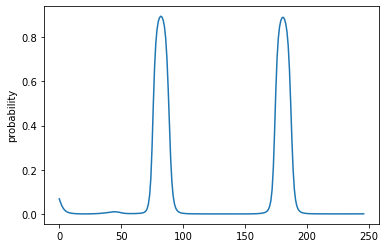

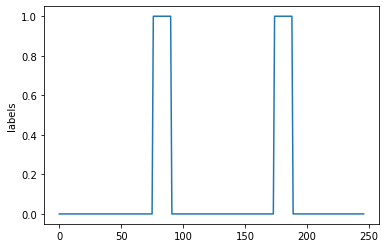

In [ ]:
net.eval()
outputs,loss = net(torch.tensor(x_tst[5:6,:,:]).float().to(device), torch.tensor(y_tst[5:6,:,:]).float().to(device))

print(loss)
plt.plot(outputs.detach().cpu().numpy()[0,:,0])
plt.ylabel('probability')
plt.show()

plt.plot(labels[5,:,0])
plt.ylabel('labels')
plt.show()

In [ ]:
def detect_triggerword(filename, model):
  plt.subplot(2, 1, 1)

  x = MFCC_feature_extraction_psf(filename)
  # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
  x = np.expand_dims(x, axis=0)
  
  predictions = model(torch.tensor(x).float().to(device))
  
  plt.subplot(2, 1, 2)
  plt.plot(predictions.detach().cpu().numpy()[0,:,0])
  plt.ylabel('probability')
  plt.show()
  return predictions

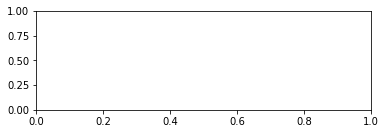

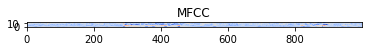

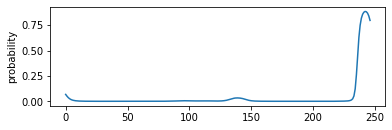

In [ ]:
preds = detect_triggerword("/content/drive/My Drive/1_2_train.wav", net)

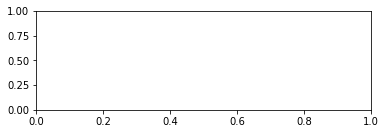

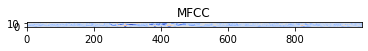

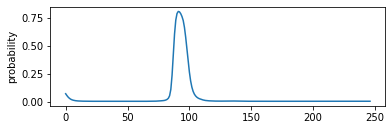

In [ ]:
preds = detect_triggerword("/content/drive/My Drive/4_8_train.wav", net)

In [ ]:
!pip install pytorch_model_summary

In [ ]:
from torchsummary import summary
from pytorch_model_summary import summary as summary_2
print(summary_2(Voice_awake_RNN(), torch.zeros((2, 13, 999)), show_input=True))
summary(net, (13,999))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/rnn.py:65: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))


-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Conv1d-1        [2, 13, 999]           5,096           5,096
     BatchNorm1d-2        [2, 26, 247]              52              52
            ReLU-3        [2, 26, 247]               0               0
         Dropout-4        [2, 26, 247]               0               0
             GRU-5        [2, 247, 26]           3,198           3,198
         Dropout-6        [2, 26, 247]               0               0
     BatchNorm1d-7        [2, 26, 247]              52              52
             GRU-8        [2, 247, 26]           2,112           2,112
     BatchNorm1d-9        [2, 16, 247]              32              32
         Linear-10        [2, 247, 16]              17              17
        Sigmoid-11         [2, 247, 1]               0               0
Total params: 10,559
Trainable params: 10,559
Non-trainable params: 0
------

In [ ]:
print(net)

Voice_awake_RNN(
  (loss_fct): BCELoss()
  (conv): Sequential(
    (0): Conv1d(13, 26, kernel_size=(15,), stride=(4,))
    (1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.8, inplace=False)
  )
  (biRNN): GRU(26, 13, batch_first=True, dropout=0.2, bidirectional=True)
  (dropout): Dropout(p=0.8, inplace=False)
  (batchNorm1): BatchNorm1d(26, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchNorm2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (RNN): GRU(26, 16, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=16, out_features=1, bias=True)
    (1): Sigmoid()
  )
)
